# Mooring system

In [1]:
import numpy as np
import pandas as pd
import math as math
from scipy import optimize
import matplotlib.pylab as plt
from matplotlib.legend_handler import HandlerLine2D

%matplotlib inline
%matplotlib widget
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
pass

In [2]:
# Constants

g=9.81
dep = 250

In [3]:
from MoorLib import moorSeg
from MoorLib import moorLine2D
from MoorLib import moorLine3D

## Solve a single line system

We first need to identify the distance at which the line should be place to get pretension of 500kN. <br>
To do this, we analyse a single line with 3 segments and build its force excursion diagram.

In [4]:
# moorSeg(L_tot=100, W_pm=376, EA=1861000000)
# moorLine3D(xanchor, yanchor, zanchor=0.0, seg=[moorSeg()])

segMat = []
segMat.append( moorSeg(150.0, 376.0, 1725000000) )
segMat.append( moorSeg(250.0, 10.9, 242000000) )
segMat.append( moorSeg(50.0, 376.0, 1725000000) )

singleLine = moorLine3D(0.0, 0.0, 0.0, seg=segMat)
xfl = singleLine.retLTot() - dep + 141.7
yfl = 0.0
zfl = dep
singleLine.solveFl_xyz( 0.0, xfl, yfl, zfl )
print( singleLine.xfl, singleLine.retFlForce(), np.linalg.norm(singleLine.retFlForce(), ord=2)/1000 )

x,y,z,segTyp = singleLine.plotLine3D(0.1)    
plt.subplots(1,1)
plt.plot( x, z )
plt.grid("on")
plt.xlabel('x')
plt.ylabel('z')
pass

341.7 (-230937.5923029373, -0.0, -443430.30854342703) 499.9626086754854


So from this we can understand that we need `xfl=341.7` to get the required 500kN pretension. <br>
For the 3 line system, each line will then be placed at a radial distance of `341.7m` in XY plane.

## Solve a 3 line system

We will construct a 3 line system, with each line consisting of 3 segments with differing properties.

The array `segMat` is used to define the order of the segments in the line, starting with the bottom line (line closest to the anchor)

In [5]:
# moorSeg(L_tot=100, W_pm=376, EA=1861000000)
# moorLine3D(xanchor, yanchor, zanchor=0.0, seg=[moorSeg()])

segMat = []
segMat.append( moorSeg(150.0, 376.0, 1725000000) )
segMat.append( moorSeg(250.0, 10.9, 242000000) )
segMat.append( moorSeg(50.0, 376.0, 1725000000) )

We position 3 lines at a distance of $341.7 + 8 m$ at various angles w.r.t the global axis. <br> The additional `8m` is to account for the distance between the centre of the body and the fairlead. 

In [6]:
nLine = 3
lineDist = 341.7 + 8
lineAng = [ 0., 120., 240. ]

lineMat=[]
for iAng in lineAng:
    xan = lineDist * np.cos( iAng * np.pi / 180.0 )
    yan = lineDist * np.sin( iAng * np.pi / 180.0 )
    lineMat.append( moorLine3D( xan, yan, 0.0, seg=segMat ) )

We position the mooring fairleads in a similar manner, w.r.t the global axis.

In [7]:
flDist = 8
V0 = 0.0
for iAng, iLine in zip(lineAng, lineMat):
    xfl = flDist * np.cos( iAng * np.pi / 180.0 )
    yfl = flDist * np.sin( iAng * np.pi / 180.0 )
    zfl = dep
    iLine.solveFl_xyz( V0, xfl, yfl, zfl )

We have now set the default position of the system.

Lets check the net force on the system.

In [8]:
Fx = sum([ iLine.retFlForce()[0] for iLine in lineMat])
Fy = sum([ iLine.retFlForce()[1] for iLine in lineMat])
Fz = sum([ iLine.retFlForce()[2] for iLine in lineMat])
print(Fx, Fy, Fz)

-5.195033736526966e-09 5.005858838558197e-09 -1330290.92563029


Let us also see the characteristics of each individual line

In [9]:
for i in range(0, nLine):
    iLine = lineMat[i]
    print(i, 'LTol', iLine.retLTot(), 'LSusp', iLine.retLSusp(),
          'LBed', iLine.retLBed(), 'H0', iLine.l2d.H0, 'VEnd', iLine.l2d.Ve, 
          np.linalg.norm([iLine.l2d.H0, iLine.l2d.Ve], ord=2)/1000)

0 LTol 450.0 LSusp 362.9703891338156 LBed 87.02961086618437 H0 230937.5923029373 VEnd -443430.30854342703 499.9626086754854
1 LTol 450.0 LSusp 362.97038913381766 LBed 87.02961086618237 H0 230937.59230294527 VEnd -443430.30854343437 499.96260867549563
2 LTol 450.0 LSusp 362.97038913381607 LBed 87.02961086618392 H0 230937.5923029396 VEnd -443430.30854342866 499.9626086754879


This is the stable position for hte system, with $0$ horizontal force. <br>
We will store this stable position for each fairlead.<br>
We can then move the system about the stable position to generate the force excursion diagram.

We also save the stable solution of `H0` and `LBed` for each line.<br>
This will be used as an initial guess for the solver in any further computation.

In [10]:
for iLine in lineMat:
    iLine.setFlRef_xyz( iLine.xfl, iLine.yfl, iLine.zfl)
    iLine.H0Start = iLine.l2d.H0
    iLine.LBedStart = iLine.retLBed()

## Force excursion diagram

We evaluate the surge force excursion diagram as follows.

In [11]:
def calcSysRestoringForce( trans_xyz, msg=False ):
    V0 = 0.0
    for iLine in lineMat:
        xfl = iLine.xflRef + trans_xyz[0]
        yfl = iLine.yflRef + trans_xyz[1]
        zfl = iLine.zflRef + trans_xyz[2]
        iLine.solveFl_xyz( V0, xfl, yfl, zfl, 
                          H0Start = iLine.H0Start, LBedStart = iLine.LBedStart )
    
    Fx = sum([ iLine.retFlForce()[0] for iLine in lineMat])
    Fy = sum([ iLine.retFlForce()[1] for iLine in lineMat])
    Fz = sum([ iLine.retFlForce()[2] for iLine in lineMat])    
    
    
    if(msg):
        #print( min([iLine.retLBed() for iLine in lineMat]) )
        for iLine in lineMat:            
            print( iLine.xfl, iLine.yfl, iLine.zfl, 
                  iLine.l2d.xe, iLine.l2d.ze, iLine.l2d.H0, iLine.retLBed() )
            
        
    return Fx, Fy, Fz

In [12]:
dx = np.arange(-10, 10+0.2, 0.2)

FRes = [ calcSysRestoringForce([idx, 0.0, 0.0]) for idx in dx ]

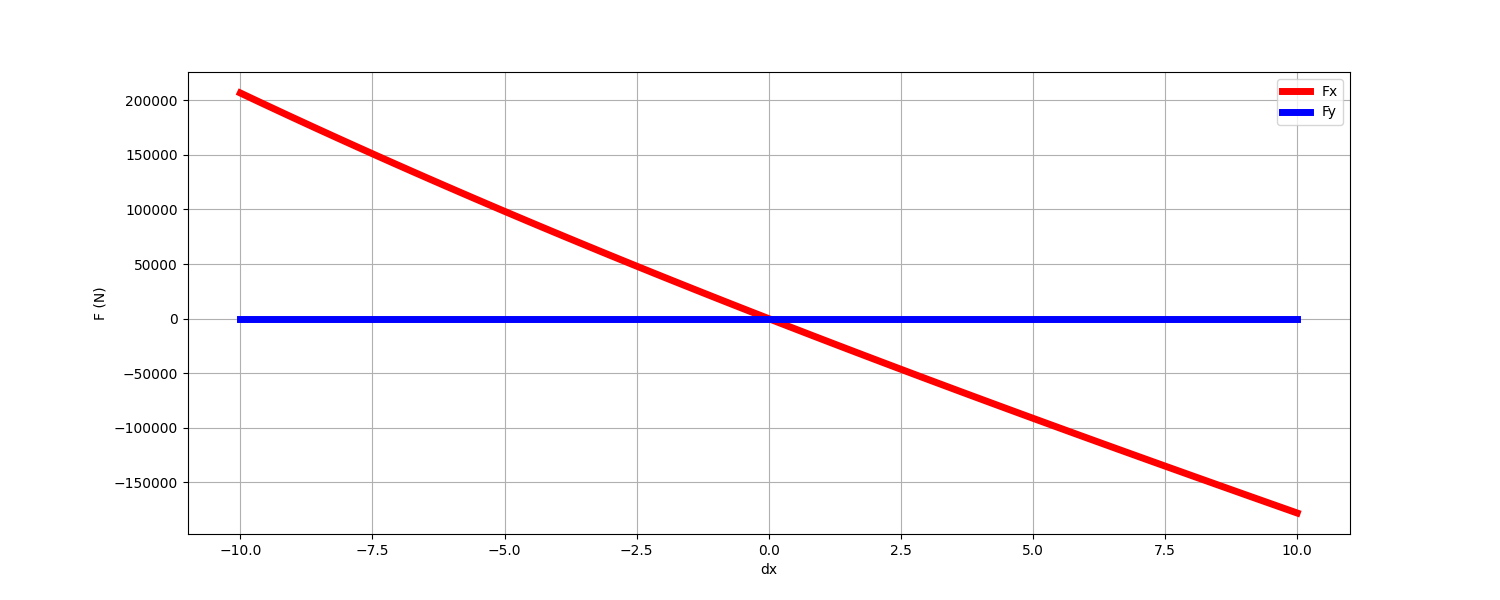

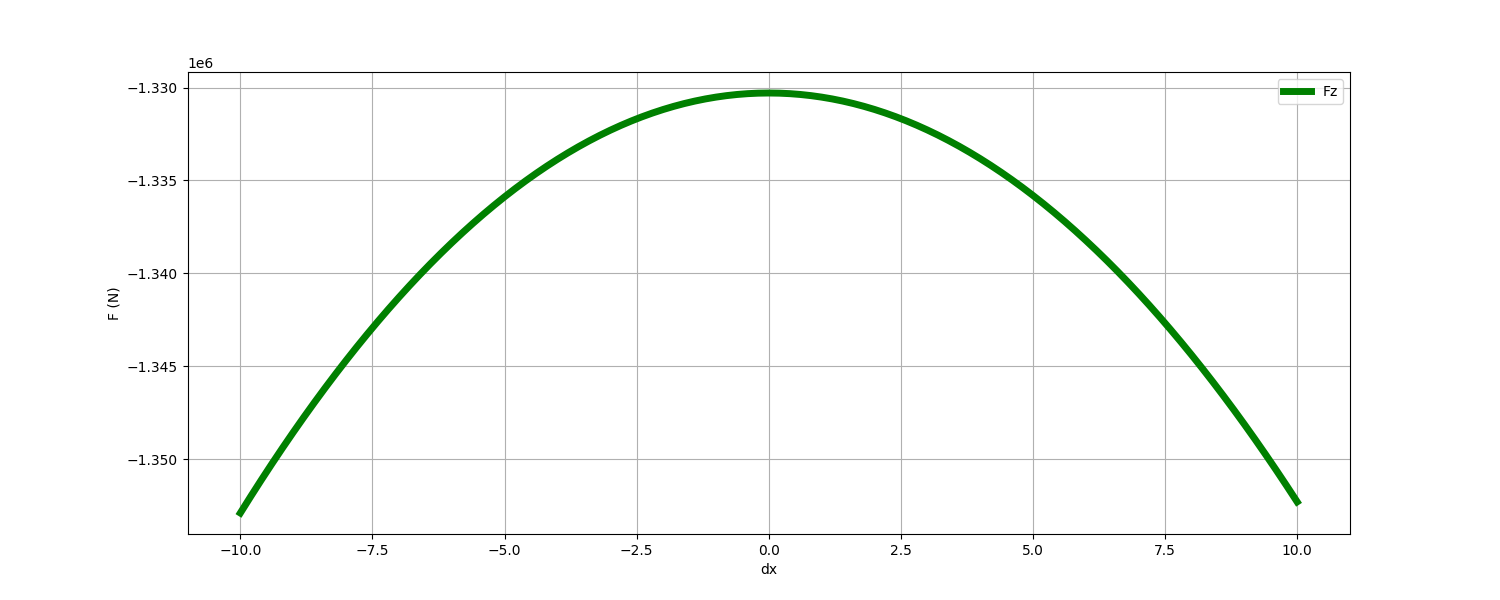

In [13]:
plt.subplots(1,1)
plt.plot( dx, [fx for fx,fy,fz in FRes], 'r-', lw=5, label='Fx')
plt.plot( dx, [fy for fx,fy,fz in FRes], 'b-', lw=5, label='Fy')
plt.grid("on")
plt.xlabel('dx')
plt.ylabel('F (N)')
plt.legend()

plt.subplots(1,1)
plt.plot( dx, [fz for fx,fy,fz in FRes], 'g-', lw=5, label='Fz')
plt.grid("on")
plt.xlabel('dx')
plt.ylabel('F (N)')
plt.legend()
pass

## Visualize the system

Translation about stable position [5.0, 8.66, 0.0]
13.0 8.66 250.0 336.81135016504425 249.9999999999999 178130.577594651 99.92741298222923
1.0000000000000022 15.58820323027551 250.0 336.8115733614353 250.00000000000009 178132.75777183767 99.92686143726974
0.9999999999999973 1.731796769724494 250.0 351.69977999680174 249.99999999999721 376763.1815322974 55.105138941383395
(-103313.49233107491, -178940.05341283145, -1352899.6562535837)


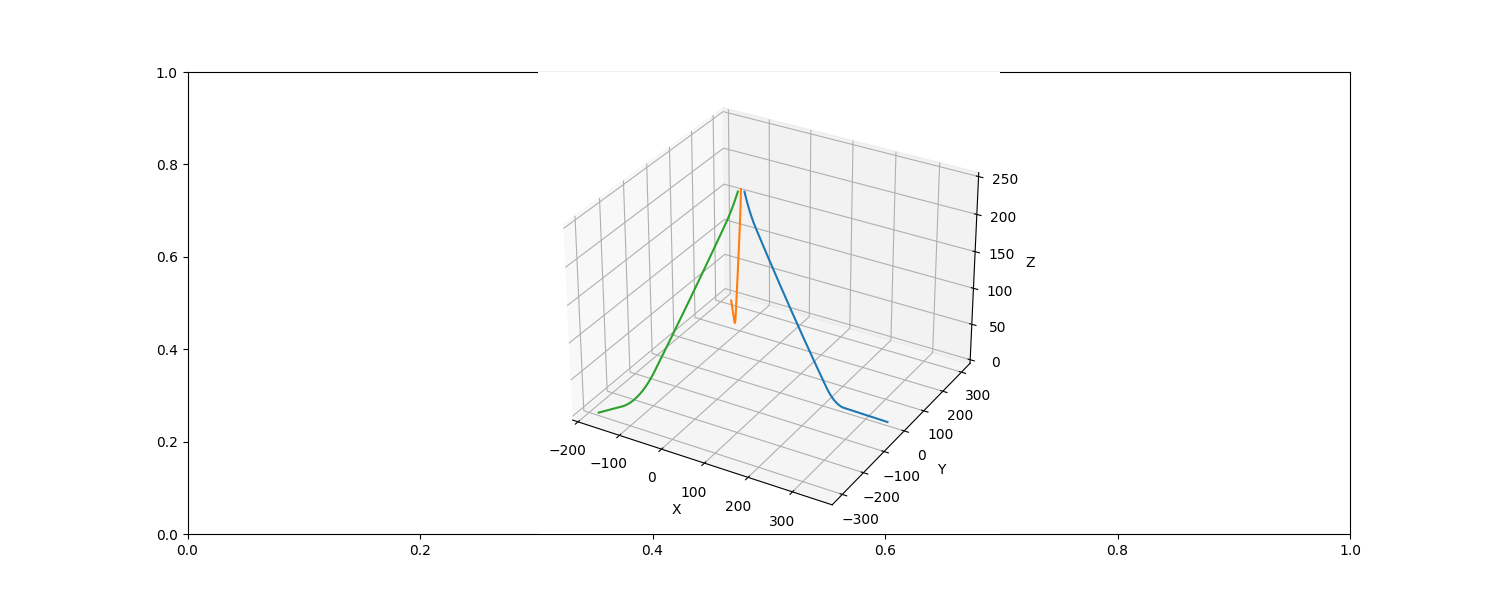

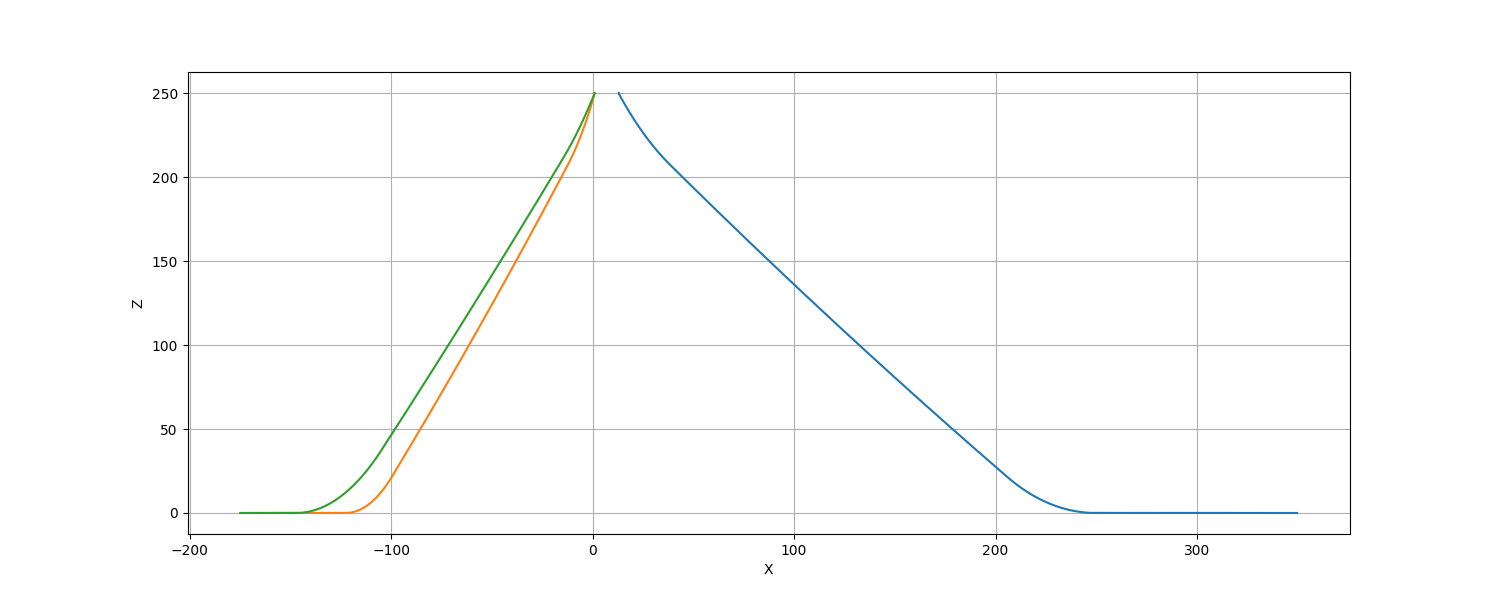

In [14]:
trans_xyz = [5.0, 8.66, 0.0]
print('Translation about stable position', trans_xyz)
print( calcSysRestoringForce( trans_xyz, msg=True ) )


# 3D plot of the system
plt.subplots(1,1)
ax = plt.axes(projection='3d')
#ax.view_init(90, 270)
for iLine in lineMat:
    x,y,z,segTyp = iLine.plotLine3D(0.1)    
    plt.plot(x,y,z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.grid("on")
#plt.axis("equal")

# 2D Views
f, (ax1, ax2) = plt.subplots(1,2)
for iLine in lineMat:
    x,y,z,segTyp = iLine.plotLine3D(0.1)    
    ax1.plot(x,y)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()

for iLine in lineMat:
    x,y,z,segTyp = iLine.plotLine3D(0.1)    
    ax2.plot(y,z)
ax2.set_xlabel('Y')
ax2.set_ylabel('Z')
ax2.grid()

plt.subplots(1,1)
for iLine in lineMat:
    x,y,z,segTyp = iLine.plotLine3D(0.1)    
    plt.plot(x,z)
plt.xlabel('X')
plt.ylabel('Z')
plt.grid()


pass